# Rydberg excitations

### TODO:
 * add Louvillian op
 * add in realistic experimental parameters, i.e. insufficient blue Rabi frequency
 * for larger more gross hamiltonians (e.g. multi-atom rydberg blockade
 stuff), consider using either of the following:
   * generalized methods from stirap_symbolic.ipynb; may want to code in the RWA though... 
   * writing a function to spit out the rhs of the von neumann eqs using the general result for diagonal/off-diagonal terms for a given hamiltonian

In [1]:
%matplotlib inline

In [2]:
from numpy import *
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
import time

from physconsts import *
from rbconsts import *
from amophys import cc

from atomsim import AtomSim

## Coherent Rabi Oscillations

In [3]:
def derivs(y0,t,O1,O2,D1,D2):
    """
    Returns RHS of Von Neumann/Liouville eq for values at time t
    'y0': the unraveled non-redundant elements of the density matrix. e.g., 
        rho = [[r11,  r12,  r13], 
               [r12*, r22,  r23],
               [r13*, r23*, r33]] 
        ==> y0 = [r11, r12, r22, r23, r33]
    't': time
    'O1,2': field 1,2 Rabi frequency
    'D1,2': field 1,2 detuning
    """
    r11,r12,r13,r22,r23,r33 = y0 # 
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

In [4]:
## set up the simulation 
rho0 = zeros(6, complex)
rho0[0] = 1 + 0j # population starts in ground state

w = 10
dt = 20
t_exp = 120
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

sim = AtomSim(rho0, func, t_exp, tcentered=True, fields=[O1, O2])

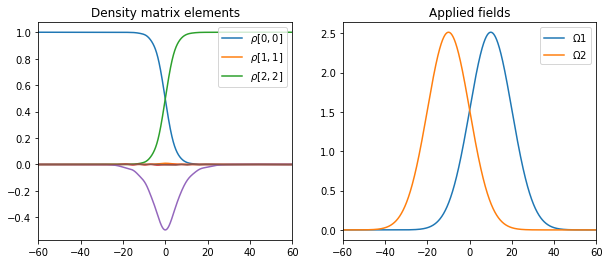

In [8]:
rho, t = sim.runsim()
kwargs = {'figsize':(10,4)}
fig, axes = sim.plots(show=['populations', 'fields'], coherences=True,
                      kwargs=kwargs)

## STIRAP 
### Conditions for STIRAP
 1. The mixing angle θ(t) of Eq. (12) varies slowly (adiabatically). 
 2. The P pulse is negligible at the start of the pulse sequence (|θ| → 0 mod π). 
 3. The S pulse is negligible at the termination of the pulse sequence (jθj → π∕2 mod π). 
 4. The two-photon detuning remains zero, i.e., δ = 0. 
 5. The single-photon detuning Δ is constant (optimally zero). 

### 3 level STIRAP

In [3]:
def derivs(y0,t,O1,O2,D1,D2):
    """
    Returns RHS of Von Neumann/Liouville eq for values at time t
    'y0': the unraveled non-redundant elements of the density matrix. e.g., 
        rho = [[r11,  r12,  r13], 
               [r12*, r22,  r23],
               [r13*, r23*, r33]] 
        ==> y0 = [r11, r12, r22, r23, r33]
    't': time
    'O1,2': field 1,2 Rabi frequency
    'D1,2': field 1,2 detuning
    """
    r11,r12,r13,r22,r23,r33 = y0 # 
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

In [4]:
## set up the simulation 
rho0 = zeros(6, complex)
rho0[0] = 1 + 0j # population starts in ground state

w = 10
dt = 20
t_exp = 120
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

sim = AtomSim(rho0, func, t_exp, tcentered=True, fields=[O1, O2])

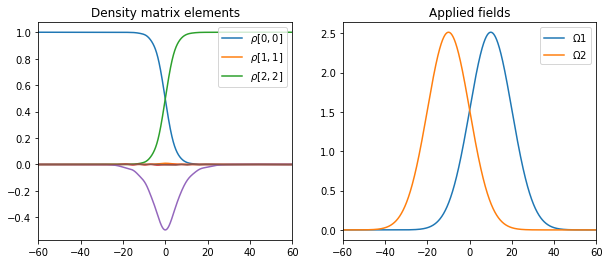

In [8]:
rho, t = sim.runsim()
kwargs = {'figsize':(10,4)}
fig, axes = sim.plots(show=['populations', 'fields'], coherences=True,
                      kwargs=kwargs)